# Brief decription of the Project

(Blurb about ride sharing and bikes)

Making use of the data made available by Lyft, I sought to learn more about Bike Sharing usage in San Francisco.

Specifically, the goal of this project is 3-fold:

- Quantify the business trends over time.

- Investigate the user profile along multiple dimensions.

- Forecast daily bike usage.


## 1 - Quantify the business trends over time.

Total Number of trips per month for the last 3 years

Trip duration distribution

Trip start time distribution: weekdays vs weekends

Trip Distance distribution: weekdays vs weekends

All to all flow chart of trips between stations: year by year

Analyze dimensionality of the data (build n_station X n_days matrix and run PCA on daily trips/start station) 


## 2 - Investigate the user profile along multiple dimensions.

Median user age over time

Age distribution by gender. 

Gender gap in user profile over time.

Pairwise analysis of start time, trip duration and age - do users cluster over certain features?

Is distance inversely correlated with age?

## 3 - Forecast daily bike usage.


How well can you predict #trips a day based on historical data?

Does more past data help or hurt predictions?

Is weather data predictive or postdictive of #trips? 

Can NN beat simple forecasting analyses (different flavors from basic next day prediction to Linear Regression)?
Play with window size 


## Data used and licensing

The Data: https://www.lyft.com/bikes/bay-wheels/system-data

Each trip is anonymized and includes:

Trip Duration (seconds)

Start Time and Date

End Time and Date

Start Station ID

Start Station Name

Start Station Latitude

Start Station Longitude

End Station ID

End Station Name

End Station Latitude

End Station Longitude

Bike ID

User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

Member Year of Birth

Member Gender


In [1]:
# imports
%matplotlib inline
import numpy as np
import glob
import math
import scipy.stats as spstats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#import plotly.graph_objects as go

In [2]:
# Define data source

extension = 'csv'
all_filenames = [i for i in glob.glob('LyftData/*.{}'.format(extension))]
all_filenames_sorted = sorted(all_filenames)

In [3]:
# Define how data frames will be created  (1 per year)

def create_dataframe_year(year,file_list):
    dateparse = lambda x: pd.datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S')
    data_frame = pd.concat([pd.read_csv(f, parse_dates=['start_time'], date_parser=dateparse) for f in file_list if year in f ])
    return data_frame

In [4]:
# Create one dataframe per year

data_frame_2017 = create_dataframe_year(year = '2017',file_list = all_filenames_sorted)
data_frame_2018 = create_dataframe_year(year = '2018',file_list = all_filenames_sorted)
data_frame_2019 = create_dataframe_year(year = '2019',file_list = all_filenames_sorted)

/Users/diogopeixoto/anaconda3/envs/time_series_prediction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/diogopeixoto/anaconda3/envs/time_series_prediction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/diogopeixoto/anaconda3/envs/time_series_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [5]:
# Sort monthly dataframes

data_frame_2017_sorted = data_frame_2017.sort_values(by=['start_time'])
data_frame_2018_sorted = data_frame_2018.sort_values(by=['start_time'])
data_frame_2019_sorted = data_frame_2019.sort_values(by=['start_time'])

## Business and usage trends over time

In [6]:
# Define function to extract monthly features of interest

def extract_monthly_features(data_frame, year,birth_year_percentile_low=5,birth_year_percentile_high=95):
    
    age_percentiles_month = np.zeros((12,2))
    
    _col = ['num_trips', 'median_trip_duration', 'median_user_age','high_age_percentile','low_age_percentile', 
            'percent_user_female','percent_user_subscriber']
#     month_name = data_frame["start_time"].apply(lambda x: str(x.month + "_" + year).unique()
    month_names = data_frame["start_time"].apply(lambda x: x.month_name())

    uniq_m_names = month_names.unique()
    df_labels = month_names.apply(lambda x: str(x) + '_' + year).unique()
    df = pd.DataFrame(index=df_labels, columns=_col)
    #print(df.index)
        
    for df_label, m_name in zip(df_labels, uniq_m_names):
        
        data_frame_month = data_frame[month_names == m_name]
        if not data_frame_month.empty:
            # Total number of trips/month
            num_trips_tmp = data_frame_month.shape[0]
            
            # Median duration of trips/month
            median_duration_tmp = np.nanmedian(data_frame_month['duration_sec'])       
            
            # Median age of trips per month for the 3 years
            median_birth_year_tmp = np.nanmedian(data_frame_month['member_birth_year'])
            median_age_tmp = float(year) - median_birth_year_tmp
            high_age_percentile_tmp = float(year) - np.nanpercentile(data_frame_month['member_birth_year'], birth_year_percentile_low)
            low_age_percentile_tmp = float(year) - np.nanpercentile(data_frame_month['member_birth_year'], birth_year_percentile_high)
            
            
            # Male and female percentage of trips per month for the 3 years
            num_males_tmp = sum(data_frame_month['member_gender'] == "Male")
            num_females_tmp = sum(data_frame_month['member_gender'] == "Female")
            
            percent_female_tmp = num_females_tmp/(num_females_tmp + num_males_tmp)
            percent_gender_report = (num_females_tmp + num_males_tmp)/num_trips_tmp
            
            # User type percentage per month for the 3 years
            num_subscribers_tmp = sum(data_frame_month['user_type'] == "Subscriber")
            num_customers_tmp = sum(data_frame_month['user_type'] == "Customer")
            percent_subscriber_tmp = num_subscribers_tmp/(num_subscribers_tmp + num_customers_tmp)
            #print(m_name, df_label)
            df.loc[df_label] = [num_trips_tmp,median_duration_tmp,median_age_tmp,high_age_percentile_tmp, 
                                low_age_percentile_tmp,percent_female_tmp,percent_subscriber_tmp] 
    
    return df
    

In [7]:
# Create dataframes of extracted monthly features and concatenate them in a continuous df
df_monthly_2017 = extract_monthly_features(data_frame_2017_sorted,"2017")
df_monthly_2018 = extract_monthly_features(data_frame_2018_sorted,"2018")
df_monthly_2019 = extract_monthly_features(data_frame_2019_sorted,"2019")
df_new = pd.concat([df_monthly_2017,df_monthly_2018,df_monthly_2019], axis=0)

In [8]:
# Define function to plot monthly features of interest
def plot_monthly_features(current_df):
    # Create Fig and gridspec
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_ul = fig.add_subplot(grid[0, 0])
    ax_ur = fig.add_subplot(grid[0, 1])
    ax_ll = fig.add_subplot(grid[1, 0])
    ax_lr = fig.add_subplot(grid[1, 1])


    # plot on the upper left
    monthly_counts = current_df.num_trips
    ax_ul.plot(monthly_counts, color='deeppink')
    ax_ul.set_xlim(0, len(monthly_counts))
    ax_ul.set(ylabel = 'number of trips /month')
    ax_ul.yaxis.label.set_fontsize(14)
    xlabels = current_df.index
    ax_ul.set_xticklabels(xlabels, rotation=90)

    # plot on the upper right
    median_duration = current_df.median_trip_duration
    ax_ur.plot(median_duration, color='deeppink')
    ax_ur.set_xlim(0, len(median_duration))
    ax_ur.set(ylabel = 'median trip duratyion(s)')
    ax_ur.yaxis.label.set_fontsize(14)
    ax_ur.set_xticklabels(xlabels, rotation=90)

    # plot on the lower left
    median_age = current_df.median_user_age
    high_age_percentile = current_df.high_age_percentile
    low_age_percentile = current_df.low_age_percentile
    ax_ll.plot(median_age, color='deeppink')
    ax_ll.plot(high_age_percentile, color='black')
    ax_ll.plot(low_age_percentile, color='green')
    ax_ll.set_xlim(0, len(median_age))
    ax_ll.set(ylabel = 'median age(years)')
    ax_ll.yaxis.label.set_fontsize(14)
    ax_ll.set_xticklabels(xlabels, rotation=90)

    # plot on the lower right
    percent_female = current_df.percent_user_female
    percent_subscribers = current_df.percent_user_subscriber
    ax_lr.plot(percent_female, color='deeppink')
    ax_lr.plot(percent_subscribers, color='black')
    ax_lr.set_xlim(0, len(percent_female))
    ax_lr.set(ylabel = 'percentage of users (%)')
    ax_lr.yaxis.label.set_fontsize(14)
    ax_lr.set_xticklabels(xlabels, rotation=90)


    plt.show()

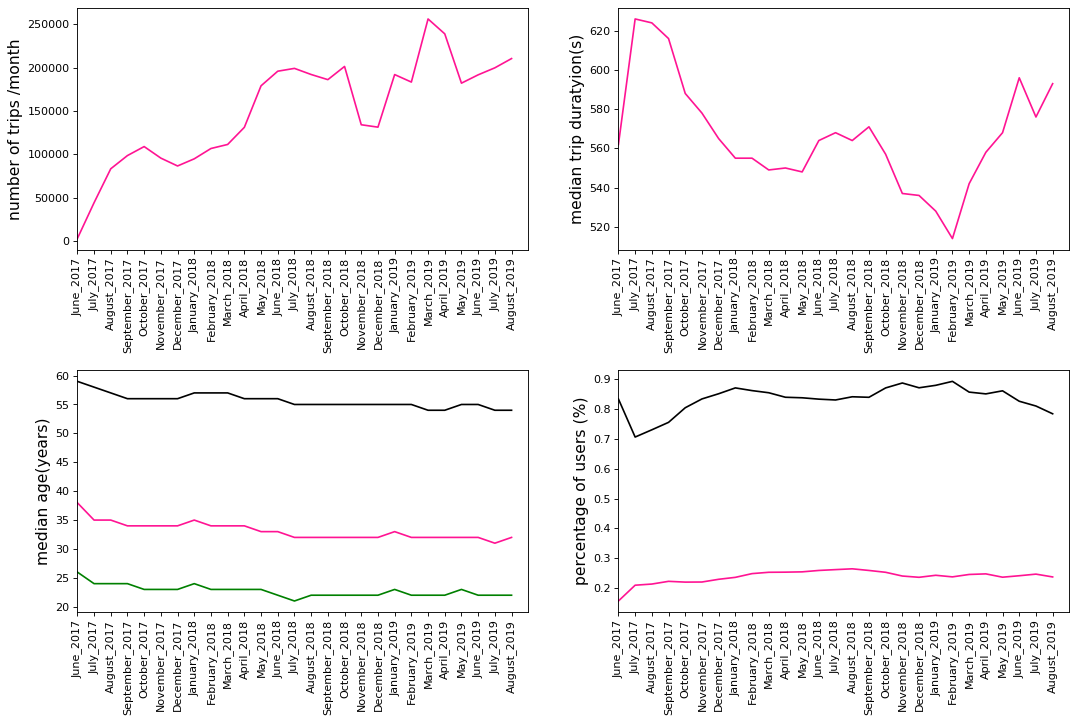

In [9]:
# Plot monthly features of interest over time 

plot_monthly_features(df_new)

## Macro usage trends

Initial impressions from the data at the macroscopic level:

- Overall the number of trips/month has been rising since the launch in the summer of 2017.

- The median trip duration has fluctuated but only within a narrow range: 500-630(s) or ~8.5-10/5 minutes.

- Median age as well as 5th and 95th percentile have been remarkably steady since the launch. This shows that despite the increase in the number of trips age-wise the demographic of the users has not expanded.

- Gender imbalance* in the user population is very striking and not showing any signs of improvement: % of female users has remained steady ~25%. Such a start underrepresentation should be a concern in terms of business expansion.

- High percentage of users who are subscribers (~80%) indicates the product is potentially "sticky", meaning users will repeatedly use the app/service over time, a positive indication for the business. A more detailed analysis of individual user behavior would require a user ID which is unfortunately not available.   

 
*Gender was reported in a binary way in the available data. While non-inclusive, "Male" and "Female" breakdown is the only possible sorting. Importantly this imbalance cannot be explained solely by users underreporting their gender since for over 90% of the rides the users chose one of the two available options.

An interesting breakdown of usage is weekdays vs weekends. From the business side, understanding the different user types can be quite important for guiding decisions. 

In [12]:
# Define function to test and plot differences in usage features between weekdays and weekends

def compare_week_to_weekend(data_frame):
    
    #Mondays are coded as 0 and Sunday as 6
    week_day_list = data_frame["start_time"].apply(lambda x: x.weekday())
    data_frame_week = data_frame[week_day_list < 5]
    data_frame_week_end = data_frame[week_day_list >= 5]
    
    duration_week = data_frame_week['duration_sec']
    duration_week_end = data_frame_week_end['duration_sec']
    
    start_time_week = data_frame_week['start_time'].apply(lambda x: x.hour)
    start_time_week_end = data_frame_week_end['start_time'].apply(lambda x: x.hour)
    
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_ul = fig.add_subplot(grid[0, 0])
    #sns.kdeplot(start_time_week, shade=True, color="g", label="Week", alpha=.7)
    sns.distplot(start_time_week, color="g", label="Week", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    #sns.kdeplot(start_time_week_end, shade=True,  color="dodgerblue", label="Weekend", alpha=.7)
    sns.distplot(start_time_week_end, color="dodgerblue", label="Weekend", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    
    ax_ur = fig.add_subplot(grid[0, 1])
    sns.distplot(duration_week, color="g", label="Week", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    sns.distplot(duration_week_end, color="dodgerblue", label="Weekend", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    ax_ur.set_xlim(0, 5000)
#     sns.kdeplot(duration_week, shade=True, color="g", label="Week", alpha=.7)
#     sns.kdeplot(duration_week_end, shade=True,  color="dodgerblue", label="Weekend", alpha=.7)
    
    

    # Median duration of trips: weekdays vs weekends
    median_duration_week = np.nanmedian(duration_week)       
    median_duration_week_end = np.nanmedian(duration_week_end)
    
   
    # Trip duration distribution: weekdays vs weekends
    # Do binning
    statistcs, pvalue = spstats.stats.ranksums(data_frame_week['duration_sec'],data_frame_week_end['duration_sec'])
    print("median trip duration on week days: ", median_duration_week)
    print("median trip duration on weekends: ", median_duration_week_end)
    print("p-value ranksum test:", pvalue)
    
    
    # Trip start time distribution: weekdays vs weekends
    # Do binning
    
    return

median trip duration on week days:  570.0
median trip duration on weekends:  768.0
p-value ranksum test: 0.0
median trip duration on week days:  541.0
median trip duration on weekends:  650.0
p-value ranksum test: 0.0
median trip duration on week days:  547.0
median trip duration on weekends:  633.0
p-value ranksum test: 0.0


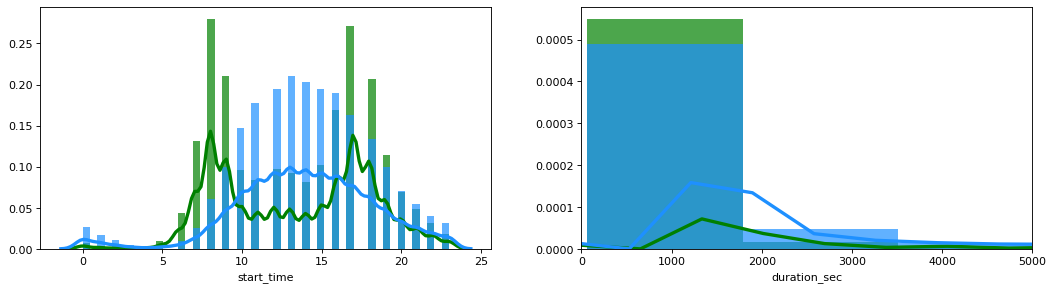

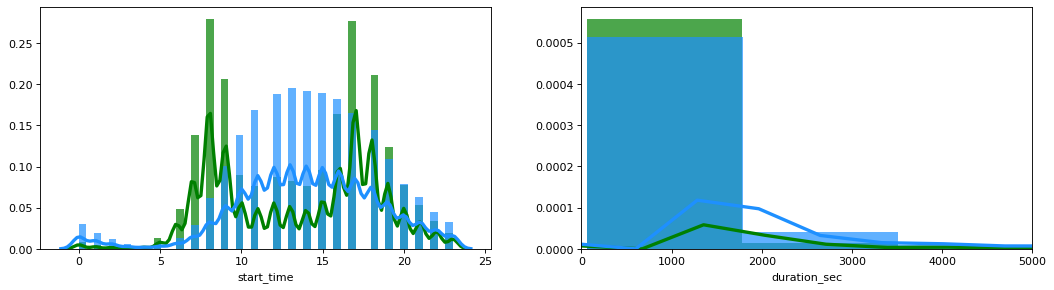

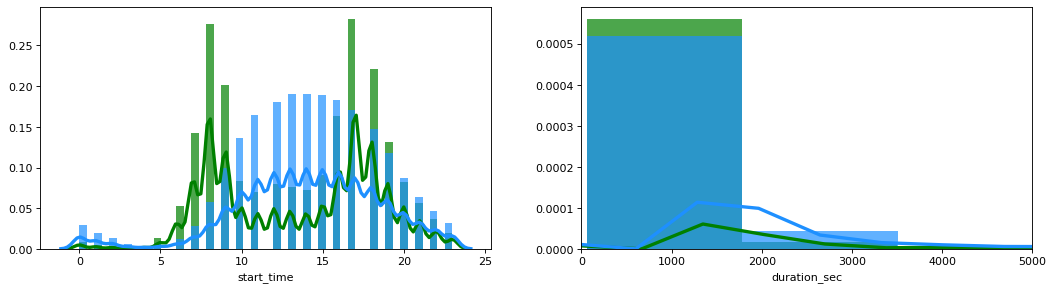

In [13]:
# Compare differences in usage features between weekdays and weekends for all 3 years separately
compare_week_to_weekend(data_frame_2017_sorted)
compare_week_to_weekend(data_frame_2018_sorted)
compare_week_to_weekend(data_frame_2019_sorted)

## Weekdays vs Weekends

There are significant differences between week and weekend usage. 

- The distribution of start times is basically bimodal during the week with peaks around 7-8 am and 4-5 pm.
- The duration of trips is consistently longer on the weekends with a difference in medians ranging between 90-200 seconds (and highly significant). 


In [15]:
# (OPTIONAL) Pairwise analysis of start time, trip duration and age - do users cluster over certain dimensions

A finer understanding of usage dynamics can only be attained at a finer scale by sorting trips by day and station

In [16]:
# Define function to build a matrix (n_station X n_days) of daily trips from each start station
    
def make_trip_count_matrix(data_frame):
    date_values = data_frame["start_time"].apply(lambda x: x.date().strftime('%Y-%m-%d'))
    unique_date_values = date_values.unique()
    
    unique_start_station_id = data_frame["start_station_id"].unique()
    
    
    num_stations = len(unique_start_station_id)
    num_days = len(unique_date_values)
    trip_count_matrix = np.empty((num_stations,num_days))
    

    print("Number of stations", num_stations, "Number of days", num_days)   
    
    for i, elem_i in enumerate(unique_date_values):
        day_inds = date_values == elem_i
        data_frame_day = data_frame[day_inds]  
        for k, elem_k in enumerate(unique_start_station_id):
            count_tmp = sum(data_frame_day['start_station_id'] == elem_k)
            trip_count_matrix[k,i] = count_tmp
                                
    
    df = pd.DataFrame(index=unique_start_station_id, columns=unique_date_values, data=trip_count_matrix)
    
    return df

In [28]:
df_daily_2017 = make_trip_count_matrix(data_frame_2017_sorted)

Number of stations 272 Number of days 187


In [38]:
df_daily_2018 = make_trip_count_matrix(data_frame_2018_sorted)

Number of stations 332 Number of days 365


In [29]:
df_daily_2019 = make_trip_count_matrix(data_frame_2019_sorted)

Number of stations 382 Number of days 243


In [40]:
def make_daily_trip_figures(df):
    # Create Fig and gridspec
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    
    daily_counts = df.sum(axis=0)
    station_counts = df.sum(axis=1)
    
    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1])

    # heatmap on main ax
    ax_main.pcolor(df, cmap='hot_r')
    ax_main.set_xticks(range(1, len(daily_counts), 10))
    xlabels = ax_main.get_xticks()#.tolist()
    ax_main.set_xticklabels(xlabels, rotation=90)
    ax_main.yaxis.label.set_fontsize(14)


    # plot on the bottom
    
    ax_bottom.plot(daily_counts, color='deeppink')
    ax_bottom.set_xlim(0, len(daily_counts))
    ax_bottom.set(ylabel = 'number of trips')
    ax_bottom.yaxis.label.set_fontsize(14)

    # plot in the right
    
    ax_right.plot(station_counts,range(0,len(df)))
    ax_right.set_ylim(0, len(station_counts))
    ax_right.set_yticklabels([])
    ax_right.set_yticks([])
    ax_right.set(xlabel = 'number of trips')
    ax_right.xaxis.label.set_fontsize(14)

    # Decorations
    ax_main.set(title='Heatmap of trips across days and stations', xlabel='days', ylabel='stations')
    ax_main.title.set_fontsize(20)
    ax_main.xaxis.label.set_fontsize(14)
    ax_main.yaxis.label.set_fontsize(14)
    for item in (ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(10)

    # Hide labels to right/bottom plots
    ax_bottom.set_xticklabels([])
    ax_bottom.set_xticks([])

    plt.show()
    return

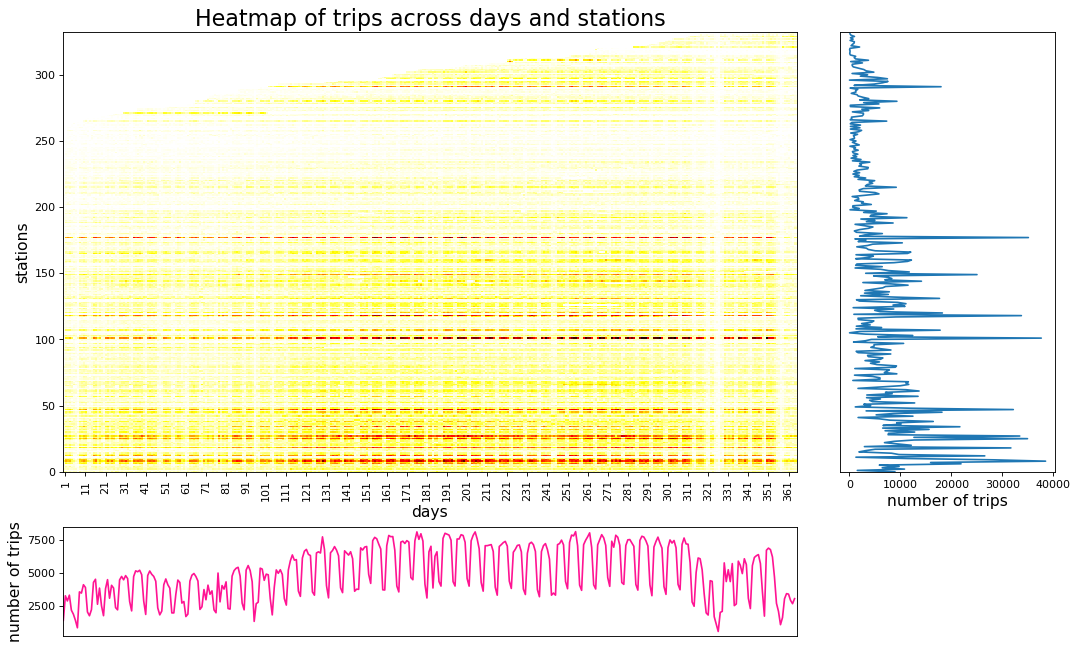

In [41]:
make_daily_trip_figures(df_daily_2018)

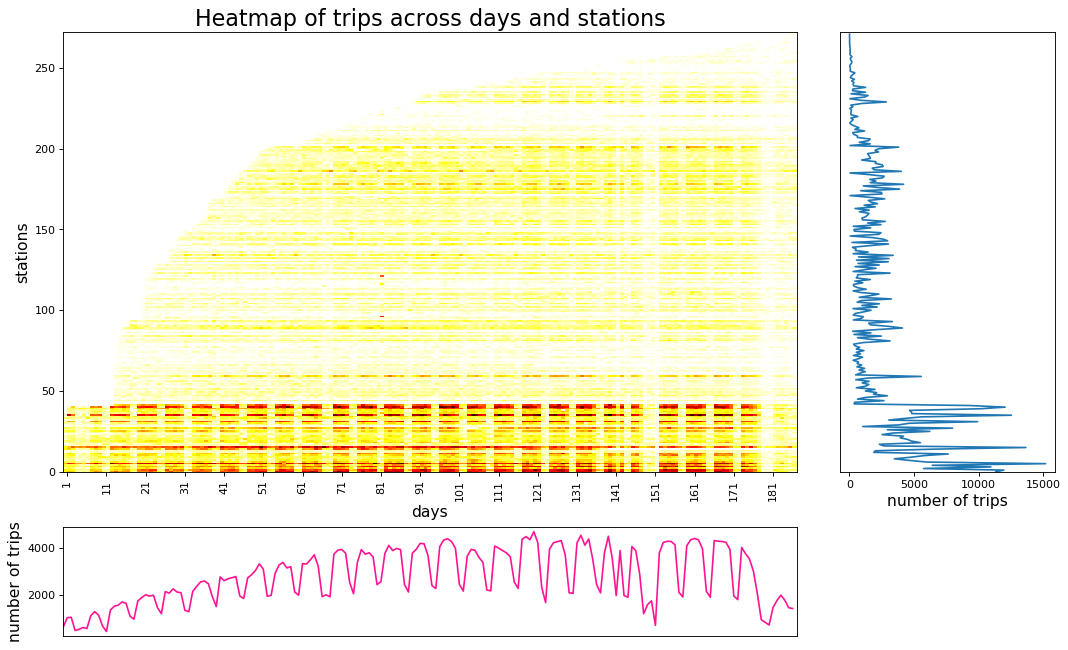

In [44]:
def pairwise_correlation_matrices(df):    
    # Pairwise correlation between stations and between days
    station_corr = df.T.corr(method='pearson')
    day_corr = df.corr(method='pearson')


    # Define the axes
    fig,(ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2)

    station_im = ax1.imshow(station_corr,  cmap='Reds', interpolation='none')
    cbar1 = plt.colorbar(station_im,ax = ax1, spacing='proportional',
                    orientation='vertical', shrink=0.95)
    cbar1.ax.tick_params(labelsize=12) 
    ax1.set(title='Correlation Matrix of station trips across days', xlabel='station', ylabel='station')
    ax1.title.set_fontsize(18)
    ax1.yaxis.label.set_fontsize(16)
    ax1.xaxis.label.set_fontsize(16)

    for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(12)


    days_im = ax2.imshow(day_corr,  cmap='hot_r', interpolation='none')
    cbar2 = plt.colorbar(days_im,ax = ax2, spacing='proportional',
                    orientation='vertical', shrink=0.95)
    cbar2.ax.tick_params(labelsize=12) 
    ax2.set(title='Correlation Matrix of daily trips across stations', xlabel='day', ylabel='day')
    ax2.title.set_fontsize(18)
    ax2.yaxis.label.set_fontsize(16)
    ax2.xaxis.label.set_fontsize(16)

    for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(12)

    plt.show()
    
    return    

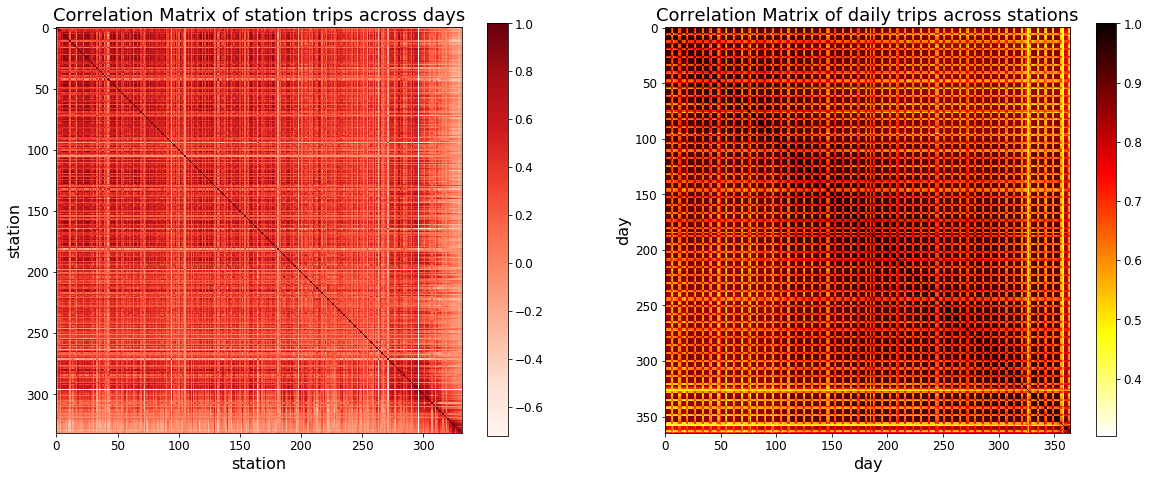

In [48]:
pairwise_correlation_matrices(df_daily_2018)

In [20]:
#(OPTIONAL) calculate distance matrix from latitude

In [21]:
#(OPTIONAL) Plot correlation between pairwise correlation and distance

In [22]:
# Analyze dimensionality of the data (build n_station X n_days matrix and run PCA on daily trips/start station) 

In [23]:
def run_PCA(matrix):
    return

In [24]:
# All to all flow chart of trips between stations: year by year

## Forecasting

In [161]:
daily_counts_2017 = df_daily_2017.sum(axis=0)
daily_counts_2018 = df_daily_2018.sum(axis=0)
daily_counts_2019 = df_daily_2019.sum(axis=0)

(187,)

In [162]:
daily_counts_2017_array = daily_counts_2017.to_numpy(copy=True).astype('float32')
daily_counts_2018_array = daily_counts_2018.to_numpy(copy=True).astype('float32')
daily_counts_2019_array = daily_counts_2019.to_numpy(copy=True).astype('float32')
daily_counts_2017_array.dtype

dtype('float32')

In [195]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
# Define function to create windowed dataset with features and labels

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
#     for x,y in dataset:
#         print("x = ", x.numpy())
#         print("y = ", y.numpy())
    return dataset

552

In [233]:
# Create Train and Test sets

full_series = np.concatenate((daily_counts_2017_array,daily_counts_2018_array,daily_counts_2019_array))
time_real = np.arange(len(full_series), dtype="float32")
split_time_real = len(daily_counts_2017_array) + len(daily_counts_2018_array)

full_series_mean = np.mean(full_series)
full_series_std = np.std(full_series)
full_series_z = spstats.zscore(full_series)

x_train_real = full_series[:split_time_real]
x_valid_real = full_series[split_time_real:]

x_train_real_z = full_series_z[:split_time_real]
x_valid_real_z = full_series_z[split_time_real:]


# x_train_real = np.concatenate((daily_counts_2017_array,daily_counts_2018_array))
# x_train_real_z = spstats.zscore(x_train_real)
# x_valid_real = daily_counts_2019_array

time_train_real = time_real[:split_time_real]
time_valid_real = time_real[split_time_real:]

# Define parameters
window_size_real = 20
batch_size_real = 32
shuffle_buffer_size_real = 1000

dataset_real = windowed_dataset(x_train_real_z, window_size_real, batch_size_real, shuffle_buffer_size_real)


In [249]:
#How well can you predict #trips a day based on historical data?
l0 = tf.keras.layers.Dense(1, input_shape=[window_size_real])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
model.fit(dataset_real,epochs=100,verbose=1)

print("Layer weights {}".format(l0.get_weights()))



<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
17/17 [==============================] - 0s 20ms/step - loss: 0.9285
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.7676
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.6557
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.5936
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.5350
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.4793
Epoch 7/100
17/17 [==============================] - 0s 7ms/step - loss: 0.4386
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 0.4122
Epoch 9/100
17/17 [==============================] - 0s 7ms/step - loss: 0.3891
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 0.3650
Epoch 11/100
17/17 [==============================] - 0s 7ms/step - loss: 0.3451
Epoch 12/100
17/17 [==============

17/17 [==============================] - 0s 6ms/step - loss: 0.1104
Layer weights [array([[ 0.2971106 ],
       [-0.19754389],
       [-0.09071913],
       [-0.17330217],
       [ 0.0763269 ],
       [-0.01351223],
       [ 0.13034487],
       [ 0.12931113],
       [-0.02967742],
       [ 0.02174707],
       [ 0.16338207],
       [-0.30649146],
       [-0.13477217],
       [ 0.372551  ],
       [-0.07277112],
       [ 0.02909999],
       [ 0.09912574],
       [ 0.11445603],
       [-0.02640191],
       [ 0.5677219 ]], dtype=float32), array([-0.00697327], dtype=float32)]


1009.91064

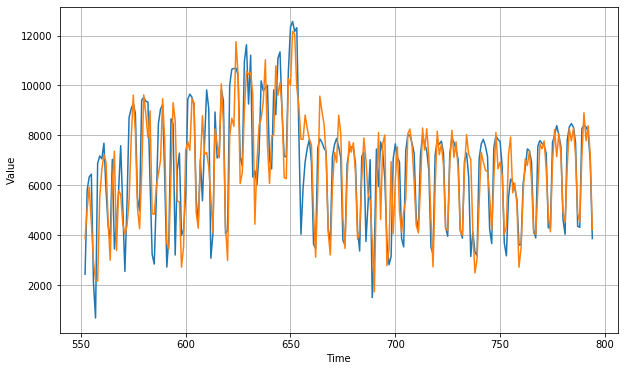

In [250]:
forecast = []

for time in range(len(full_series) - window_size_real):
    forecast.append(model.predict(full_series_z[time:time + window_size_real][np.newaxis]))

forecast_real = forecast[split_time_real-window_size_real:]
results_real = np.array(forecast_real)[:, 0, 0]


# plt.figure(figsize=(10, 6))

# plot_series(time_valid_real, x_valid_real_z)
# plot_series(time_valid_real, results_real)

# tf.keras.metrics.mean_absolute_error(x_valid_real_z, results_real).numpy()

plt.figure(figsize=(10, 6))

results_real_rescaled = results_real*full_series_std 
results_real_rescaled = results_real_rescaled + full_series_mean

plot_series(time_valid_real, x_valid_real)
plot_series(time_valid_real, results_real_rescaled)

tf.keras.metrics.mean_absolute_error(x_valid_real, results_real_rescaled).numpy()



In [246]:
#Can NN beat simple forecasting analyses (different flavors from basic next day prediction to Linear Regression)? Play with window size 
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size_real], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
model.fit(dataset_real,epochs=500,verbose=1)


Epoch 1/500
17/17 [==============================] - 0s 27ms/step - loss: 0.8891
Epoch 2/500
17/17 [==============================] - 0s 6ms/step - loss: 0.5800
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 0.4303
Epoch 4/500
17/17 [==============================] - 0s 9ms/step - loss: 0.3608
Epoch 5/500
17/17 [==============================] - 0s 7ms/step - loss: 0.3192
Epoch 6/500
17/17 [==============================] - 0s 8ms/step - loss: 0.2806
Epoch 7/500
17/17 [==============================] - 0s 8ms/step - loss: 0.2608
Epoch 8/500
17/17 [==============================] - 0s 7ms/step - loss: 0.2307
Epoch 9/500
17/17 [==============================] - 0s 7ms/step - loss: 0.2230
Epoch 10/500
17/17 [==============================] - 0s 7ms/step - loss: 0.2073
Epoch 11/500
17/17 [==============================] - 0s 7ms/step - loss: 0.1960
Epoch 12/500
17/17 [==============================] - 0s 9ms/step - loss: 0.1878
Epoch 13/500
17/17 [================

Epoch 102/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0640
Epoch 103/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0631
Epoch 104/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0641
Epoch 105/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0636
Epoch 106/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0627
Epoch 107/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0624
Epoch 108/500
17/17 [==============================] - 0s 9ms/step - loss: 0.0639
Epoch 109/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0617
Epoch 110/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0627
Epoch 111/500
17/17 [==============================] - 0s 15ms/step - loss: 0.0586
Epoch 112/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0572
Epoch 113/500
17/17 [==============================] - 0s 14ms/step - loss: 0.0624
Epoch 114/5

17/17 [==============================] - 0s 8ms/step - loss: 0.0504
Epoch 202/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0501
Epoch 203/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0504
Epoch 204/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0490
Epoch 205/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0504
Epoch 206/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0509
Epoch 207/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0504
Epoch 208/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0502
Epoch 209/500
17/17 [==============================] - 0s 5ms/step - loss: 0.0506
Epoch 210/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0511
Epoch 211/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0493
Epoch 212/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0498
Epoch 213/500
17/17 [=======

17/17 [==============================] - 0s 17ms/step - loss: 0.0418
Epoch 301/500
17/17 [==============================] - 0s 13ms/step - loss: 0.0447
Epoch 302/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0443
Epoch 303/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0433
Epoch 304/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0437
Epoch 305/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0443
Epoch 306/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0440
Epoch 307/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0432
Epoch 308/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0437
Epoch 309/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0437
Epoch 310/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0441
Epoch 311/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0441
Epoch 312/500
17/17 [=====

17/17 [==============================] - 0s 11ms/step - loss: 0.0404
Epoch 400/500
17/17 [==============================] - 0s 13ms/step - loss: 0.0391
Epoch 401/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0401
Epoch 402/500
17/17 [==============================] - 0s 12ms/step - loss: 0.0393
Epoch 403/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0392
Epoch 404/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0403
Epoch 405/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0409
Epoch 406/500
17/17 [==============================] - 0s 11ms/step - loss: 0.0409
Epoch 407/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0404
Epoch 408/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0397
Epoch 409/500
17/17 [==============================] - 0s 10ms/step - loss: 0.0399
Epoch 410/500
17/17 [==============================] - 0s 13ms/step - loss: 0.0412
Epoch 411/500
17/17 [

17/17 [==============================] - 0s 15ms/step - loss: 0.0361
Epoch 499/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0371
Epoch 500/500
17/17 [==============================] - 0s 15ms/step - loss: 0.0347


0.477322

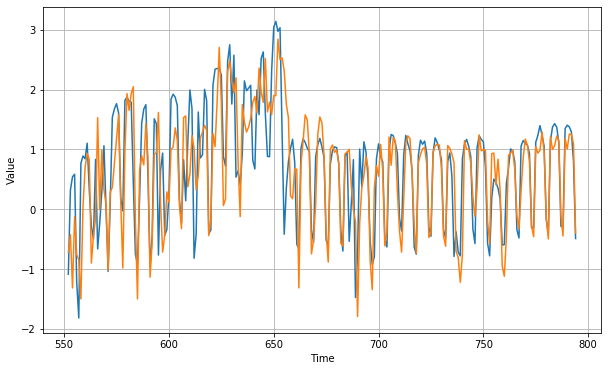

In [247]:
forecast = []

for time in range(len(full_series) - window_size_real):
    forecast.append(model.predict(full_series_z[time:time + window_size_real][np.newaxis]))

forecast_real = forecast[split_time_real-window_size_real:]
results_real = np.array(forecast_real)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid_real, x_valid_real_z)
plot_series(time_valid_real, results_real)

tf.keras.metrics.mean_absolute_error(x_valid_real_z, results_real).numpy()



1143.8223

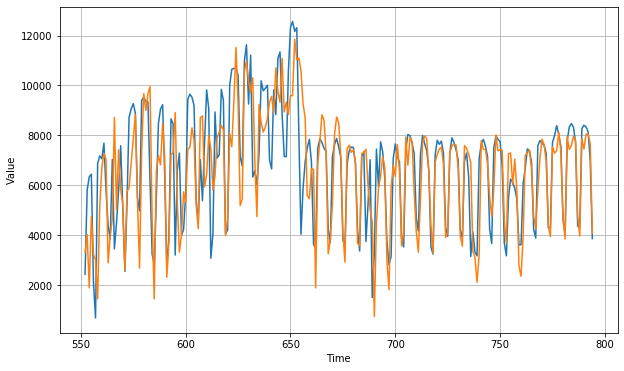

In [248]:
plt.figure(figsize=(10, 6))

results_real_rescaled = results_real*full_series_std 
results_real_rescaled = results_real_rescaled + full_series_mean

plot_series(time_valid_real, x_valid_real)
plot_series(time_valid_real, results_real_rescaled)

tf.keras.metrics.mean_absolute_error(x_valid_real, results_real_rescaled).numpy()

In [251]:
# def plot_series(time, series, format="-", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format)
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.grid(True)

# def trend(time, slope=0):
#     return slope * time

# def seasonal_pattern(season_time):
#     """Just an arbitrary pattern, you can change it if you wish"""
#     return np.where(season_time < 0.4,
#                     np.cos(season_time * 2 * np.pi),
#                     1 / np.exp(3 * season_time))

# def seasonality(time, period, amplitude=1, phase=0):
#     """Repeats the same pattern at each period"""
#     season_time = ((time + phase) % period) / period
#     return amplitude * seasonal_pattern(season_time)

# def noise(time, noise_level=1, seed=None):
#     rnd = np.random.RandomState(seed)
#     return rnd.randn(len(time)) * noise_level

# time = np.arange(4 * 365 + 1, dtype="float32")
# baseline = 10
# series = trend(time, 0.1)  
# baseline = 10
# amplitude = 40
# slope = 0.05
# noise_level = 100

# # Create the series
# series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# # Update with noise
# series += noise(time, noise_level, seed=42)

# split_time = 1000
# time_train = time[:split_time]
# x_train = series[:split_time]
# time_valid = time[split_time:]
# x_valid = series[split_time:]

# window_size = 20
# batch_size = 32
# shuffle_buffer_size = 1000

# print(series.dtype)

# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(dataset)
# l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
# model = tf.keras.models.Sequential([l0])

# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
# model.fit(dataset,epochs=100,verbose=1)

# print("Layer weights {}".format(l0.get_weights()))

# forecast = []

# for time in range(len(series) - window_size):
#     forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# forecast = forecast[split_time-window_size:]
# results = np.array(forecast)[:, 0, 0]


# plt.figure(figsize=(10, 6))

# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

# tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [ ]:
#Is weather data predictive or postdictive of #trips?